In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
from matplotlib import pyplot as plt

import copy
import pickle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [84]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [85]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}

background_classes = {'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck'}

fg1,fg2,fg3 = 0,1,2

In [86]:
dataiter = iter(trainloader)
background_data_train=[]
background_label_train=[]
foreground_data_train=[]
foreground_label_train=[]
batch_size=10

for i in range(5000):   #5000*batch_size = 50000 data points
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data_train.append(img)
      background_label_train.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data_train.append(img)
      foreground_label_train.append(labels[j])
            
foreground_data_train = torch.tensor(foreground_data_train)
foreground_label_train = torch.tensor(foreground_label_train)
background_data_train = torch.tensor(background_data_train)
background_label_train = torch.tensor(background_label_train)
    

In [87]:
dataiter = iter(testloader)
background_data_test=[]
background_label_test=[]
foreground_data_test=[]
foreground_label_test=[]
batch_size=10

for i in range(1000):   #1000*batch_size = 10000 data points
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data_test.append(img)
      background_label_test.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data_test.append(img)
      foreground_label_test.append(labels[j])
            
foreground_data_test = torch.tensor(foreground_data_test)
foreground_label_test = torch.tensor(foreground_label_test)
background_data_test = torch.tensor(background_data_test)
background_label_test = torch.tensor(background_label_test)

In [88]:
print(foreground_data_train.size())
print(foreground_data_test.size())

torch.Size([15000, 3, 32, 32])
torch.Size([3000, 3, 32, 32])


In [89]:
foreground_data_combined = torch.cat([foreground_data_train , foreground_data_test], dim=0)
foreground_label_combined = torch.cat([foreground_label_train , foreground_label_test], dim=0) 
background_data_combined = torch.cat([background_data_train , background_data_test], dim=0) 
background_label_combined = torch.cat([background_label_train , background_label_test], dim=0) 

In [90]:
print(foreground_data_train.size() , foreground_data_test.size() , foreground_data_combined.size())
print(foreground_label_train.size() , foreground_label_test.size() , foreground_label_combined.size())
print(background_data_train.size() , background_data_test.size() , background_data_combined.size())
print(background_label_train.size() , background_label_test.size() , background_label_combined.size())

torch.Size([15000, 3, 32, 32]) torch.Size([3000, 3, 32, 32]) torch.Size([18000, 3, 32, 32])
torch.Size([15000]) torch.Size([3000]) torch.Size([18000])
torch.Size([35000, 3, 32, 32]) torch.Size([7000, 3, 32, 32]) torch.Size([42000, 3, 32, 32])
torch.Size([35000]) torch.Size([7000]) torch.Size([42000])


In [91]:
def create_mosaic_img(background_data, foreground_data, foreground_label, bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]  #-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [92]:
def init_mosaic_creation(bg_size, fg_size, desired_num, background_data, foreground_data, foreground_label):
  # bg_size = 35000
  # fg_size = 15000
  # desired_num = 30000
  mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
  fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
  mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
  for i in range(desired_num):
    bg_idx = np.random.randint(0,bg_size,8)
    fg_idx = np.random.randint(0,fg_size)
    fg = np.random.randint(0,9)
    fore_idx.append(fg)
    image_list,label = create_mosaic_img(background_data, foreground_data, foreground_label ,bg_idx,fg_idx,fg)
    mosaic_list_of_images.append(image_list)
    mosaic_label.append(label)
  
  return mosaic_list_of_images, mosaic_label, fore_idx


In [174]:
mosaic_list_of_images, mosaic_label, fore_idx = init_mosaic_creation(bg_size = 42000, 
                                                                    fg_size = 15000, 
                                                                    desired_num = 30000, 
                                                                    background_data = background_data_combined, 
                                                                    foreground_data = foreground_data_train, 
                                                                    foreground_label = foreground_label_train)

In [175]:
print(len(mosaic_list_of_images),len(mosaic_label))

30000 30000


In [176]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]


In [177]:
batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [178]:
# model initialisation
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=0)
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=0)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.batch_norm1 = nn.BatchNorm2d(32)
    self.batch_norm2 = nn.BatchNorm2d(128)
    self.dropout1 = nn.Dropout2d(p=0.05)
    self.dropout2 = nn.Dropout2d(p=0.1)
    self.fc1 = nn.Linear(128,64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 10)
    self.fc4 = nn.Linear(10, 1)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.batch_norm1(x))

    x = (F.relu(self.conv2(x)))
    x = self.pool(x)
    
    x = self.conv3(x)
    x = F.relu(self.batch_norm2(x))

    x = (F.relu(self.conv4(x)))
    x = self.pool(x)
    x = self.dropout1(x)

    x = self.conv5(x)
    x = F.relu(self.batch_norm2(x))

    x = (F.relu(self.conv6(x)))
    x = self.pool(x)

    x = x.view(x.size(0), -1)

    x = self.dropout2(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [179]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.module1 = Focus().double()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=0)
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=0)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.batch_norm1 = nn.BatchNorm2d(32)
    self.batch_norm2 = nn.BatchNorm2d(128)
    self.dropout1 = nn.Dropout2d(p=0.05)
    self.dropout2 = nn.Dropout2d(p=0.1)
    self.fc1 = nn.Linear(128,64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 10)
    self.fc4 = nn.Linear(10, 3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    x = x.to("cuda")
    y = y.to("cuda")

    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])

    y1 = self.conv1(y)
    y1 = F.relu(self.batch_norm1(y1))

    y1 = (F.relu(self.conv2(y1)))
    y1 = self.pool(y1)
    
    y1 = self.conv3(y1)
    y1 = F.relu(self.batch_norm2(y1))

    y1 = (F.relu(self.conv4(y1)))
    y1 = self.pool(y1)
    y1 = self.dropout1(y1)

    y1 = self.conv5(y1)
    y1 = F.relu(self.batch_norm2(y1))

    y1 = (F.relu(self.conv6(y1)))
    y1 = self.pool(y1)

    y1 = y1.view(y1.size(0), -1)

    y1 = self.dropout2(y1)
    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = self.dropout2(y1)
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)

    return y1 , x, y

In [180]:
classify = Classification().double()
classify = classify.to("cuda")

In [181]:
import torch.optim as optim
criterion_classify = nn.CrossEntropyLoss()
optimizer_classify = optim.SGD(classify.parameters(), lr=0.01, momentum=0.9)

In [182]:
# train
nos_epochs = 300
loss_list = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    # zero the parameter gradients
    
    optimizer_classify.zero_grad()
    
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion_classify(outputs, labels) 
    loss.backward()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 40
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    

  loss_list.append(np.mean(epoch_loss))
  if(np.mean(epoch_loss) <= 0.03):
      break;
        
print('Finished Training')

[1,    40] loss: 1.099
[1,    80] loss: 1.097
[1,   120] loss: 1.096
[2,    40] loss: 1.092
[2,    80] loss: 1.087
[2,   120] loss: 1.082
[3,    40] loss: 1.077
[3,    80] loss: 1.065
[3,   120] loss: 1.054
[4,    40] loss: 1.046
[4,    80] loss: 1.037
[4,   120] loss: 1.033
[5,    40] loss: 1.003
[5,    80] loss: 0.965
[5,   120] loss: 0.915
[6,    40] loss: 0.864
[6,    80] loss: 0.804
[6,   120] loss: 0.766
[7,    40] loss: 0.713
[7,    80] loss: 0.683
[7,   120] loss: 0.641
[8,    40] loss: 0.598
[8,    80] loss: 0.581
[8,   120] loss: 0.563
[9,    40] loss: 0.519
[9,    80] loss: 0.491
[9,   120] loss: 0.499
[10,    40] loss: 0.447
[10,    80] loss: 0.452
[10,   120] loss: 0.428
[11,    40] loss: 0.379
[11,    80] loss: 0.419
[11,   120] loss: 0.406
[12,    40] loss: 0.359
[12,    80] loss: 0.365
[12,   120] loss: 0.345
[13,    40] loss: 0.311
[13,    80] loss: 0.326
[13,   120] loss: 0.341
[14,    40] loss: 0.289
[14,    80] loss: 0.290
[14,   120] loss: 0.303
[15,    40] loss: 0

In [183]:
name = "train_ds3"

In [184]:
# save model
torch.save(classify.state_dict(),"/content/drive/My Drive/Research/genralisation_on_unseen_CIFAR/"+name+".pt")

In [185]:
correct = 0
total = 0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 30000 train images: 98 %
total correct 29611
total train set images 30000


In [186]:
mosaic_list_of_images_1, mosaic_label_1, fore_idx_1 = init_mosaic_creation(bg_size = 35000, 
                                                                          fg_size = 15000, 
                                                                          desired_num = 10000, 
                                                                          background_data = background_data_train, 
                                                                          foreground_data = foreground_data_train, 
                                                                          foreground_label = foreground_label_train)

msd1 = MosaicDataset(mosaic_list_of_images_1, mosaic_label_1 , fore_idx_1)
test_loader_1 = DataLoader( msd1, batch_size= batch ,shuffle = False)

In [187]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader_1:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 93 %
total correct 9304
total train set images 10000


In [188]:
del test_loader_1
del msd1
del mosaic_list_of_images_1
del mosaic_label_1
del fore_idx_1

In [189]:
mosaic_list_of_images_2, mosaic_label_2, fore_idx_2 = init_mosaic_creation(bg_size = 7000, 
                                                                          fg_size = 15000, 
                                                                          desired_num = 10000, 
                                                                          background_data = background_data_test, 
                                                                          foreground_data = foreground_data_train, 
                                                                          foreground_label = foreground_label_train)

msd2 = MosaicDataset(mosaic_list_of_images_2, mosaic_label_2 , fore_idx_2)
test_loader_2 = DataLoader( msd2, batch_size= batch ,shuffle = False)

In [190]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader_2:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 92 %
total correct 9256
total train set images 10000


In [191]:
del test_loader_2
del msd2
del mosaic_list_of_images_2
del mosaic_label_2
del fore_idx_2

In [192]:
mosaic_list_of_images_3, mosaic_label_3, fore_idx_3 = init_mosaic_creation(bg_size = 42000, 
                                                                          fg_size = 15000, 
                                                                          desired_num = 10000, 
                                                                          background_data = background_data_combined, 
                                                                          foreground_data = foreground_data_train, 
                                                                          foreground_label = foreground_label_train)

msd3 = MosaicDataset(mosaic_list_of_images_3, mosaic_label_3 , fore_idx_3)
test_loader_3 = DataLoader( msd3, batch_size= batch ,shuffle = False)

In [193]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader_3:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 92 %
total correct 9293
total train set images 10000


In [194]:
del test_loader_3
del msd3
del mosaic_list_of_images_3
del mosaic_label_3
del fore_idx_3

In [195]:
mosaic_list_of_images_4, mosaic_label_4, fore_idx_4 = init_mosaic_creation(bg_size = 35000, 
                                                                          fg_size = 3000, 
                                                                          desired_num = 10000, 
                                                                          background_data = background_data_train, 
                                                                          foreground_data = foreground_data_test, 
                                                                          foreground_label = foreground_label_test)

msd4 = MosaicDataset(mosaic_list_of_images_4, mosaic_label_4 , fore_idx_4)
test_loader_4 = DataLoader( msd4, batch_size= batch ,shuffle = False)

In [196]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader_4:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 81 %
total correct 8114
total train set images 10000


In [197]:
del test_loader_4
del msd4
del mosaic_list_of_images_4
del mosaic_label_4
del fore_idx_4

In [198]:
mosaic_list_of_images_5, mosaic_label_5, fore_idx_5 = init_mosaic_creation(bg_size = 7000, 
                                                                          fg_size = 3000, 
                                                                          desired_num = 10000, 
                                                                          background_data = background_data_test, 
                                                                          foreground_data = foreground_data_test, 
                                                                          foreground_label = foreground_label_test)

msd5 = MosaicDataset(mosaic_list_of_images_5, mosaic_label_5 , fore_idx_5)
test_loader_5 = DataLoader( msd5, batch_size= batch ,shuffle = False)

In [199]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader_5:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 80 %
total correct 8090
total train set images 10000


In [200]:
del test_loader_5
del msd5
del mosaic_list_of_images_5
del mosaic_label_5
del fore_idx_5

In [201]:
mosaic_list_of_images_6, mosaic_label_6, fore_idx_6 = init_mosaic_creation(bg_size = 42000, 
                                                                          fg_size = 3000, 
                                                                          desired_num = 10000, 
                                                                          background_data = background_data_combined, 
                                                                          foreground_data = foreground_data_test, 
                                                                          foreground_label = foreground_label_test)

msd6 = MosaicDataset(mosaic_list_of_images_6, mosaic_label_6 , fore_idx_6)
test_loader_6 = DataLoader( msd6, batch_size= batch ,shuffle = False)

In [202]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader_6:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 81 %
total correct 8104
total train set images 10000


In [203]:
del test_loader_6
del msd6
del mosaic_list_of_images_6
del mosaic_label_6
del fore_idx_6

In [204]:
mosaic_list_of_images_7, mosaic_label_7, fore_idx_7 = init_mosaic_creation(bg_size = 35000, 
                                                                          fg_size = 18000, 
                                                                          desired_num = 10000, 
                                                                          background_data = background_data_train, 
                                                                          foreground_data = foreground_data_combined, 
                                                                          foreground_label = foreground_label_combined)

msd7 = MosaicDataset(mosaic_list_of_images_7, mosaic_label_7 , fore_idx_7)
test_loader_7 = DataLoader( msd7, batch_size= batch ,shuffle = False)

In [205]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader_7:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 91 %
total correct 9113
total train set images 10000


In [206]:
del test_loader_7
del msd7
del mosaic_list_of_images_7
del mosaic_label_7
del fore_idx_7

In [207]:
mosaic_list_of_images_8, mosaic_label_8, fore_idx_8 = init_mosaic_creation(bg_size = 7000, 
                                                                          fg_size = 18000, 
                                                                          desired_num = 10000, 
                                                                          background_data = background_data_test, 
                                                                          foreground_data = foreground_data_combined, 
                                                                          foreground_label = foreground_label_combined)

msd8 = MosaicDataset(mosaic_list_of_images_8, mosaic_label_8 , fore_idx_8)
test_loader_8 = DataLoader( msd8, batch_size= batch ,shuffle = False)

In [208]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader_8:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 90 %
total correct 9019
total train set images 10000


In [209]:
del test_loader_8
del msd8
del mosaic_list_of_images_8
del mosaic_label_8
del fore_idx_8

In [210]:
mosaic_list_of_images_9, mosaic_label_9, fore_idx_9 = init_mosaic_creation(bg_size = 42000, 
                                                                          fg_size = 18000, 
                                                                          desired_num = 10000, 
                                                                          background_data = background_data_combined, 
                                                                          foreground_data = foreground_data_combined, 
                                                                          foreground_label = foreground_label_combined)

msd9 = MosaicDataset(mosaic_list_of_images_9, mosaic_label_9 , fore_idx_9)
test_loader_9 = DataLoader( msd9, batch_size= batch ,shuffle = False)

In [211]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader_9:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 91 %
total correct 9107
total train set images 10000


In [212]:
del test_loader_9
del msd9
del mosaic_list_of_images_9
del mosaic_label_9
del fore_idx_9

In [213]:
%matplotlib inline

Text(0, 0.5, 'Training_loss')

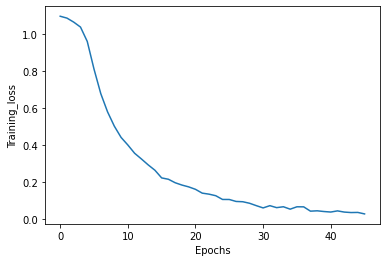

In [214]:
plt.plot(loss_list)
plt.xlabel("Epochs")
plt.ylabel("Training_loss")

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))